Imports

In [1]:
from matplotlib import pyplot as plt
from PVModel import PVModel
import numpy as np
from scipy.signal import savgol_filter

The implementation of the P(V) function for all models is realized as methods of the PVModel class.

In [2]:
V = np.linspace(0, 10, 500)

model = PVModel(V)
model.calculate_Plin(a=5.0, b=0.0)
model.calculate_Pexp(P0=2.0, alfa=0.5, V0=0.0)
model.calculate_Plog(Pmax=120.0, beta=1.0, V50=5.0)

Pressure values are smoothed before differentiation using the scipy library and the savgol_filter method.

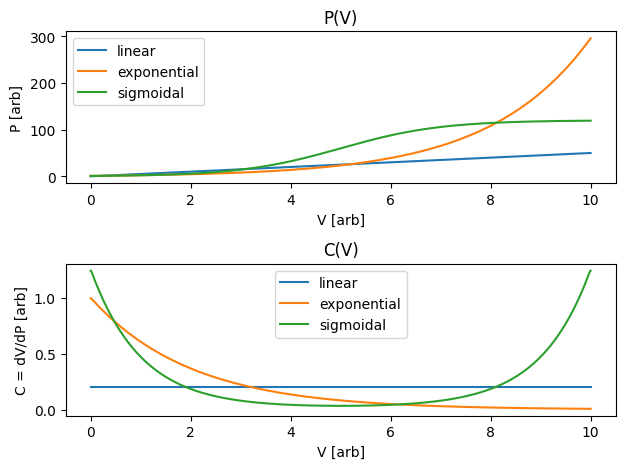

In [3]:
P_lin_smooth = savgol_filter(model.P_lin, window_length=11, polyorder=3)
P_exp_smooth = savgol_filter(model.P_exp, window_length=11, polyorder=3)
P_log_smooth = savgol_filter(model.P_log, window_length=11, polyorder=3)

fig, axs = plt.subplots(2)
for P, label in [
    (P_lin_smooth, "linear"),
    (P_exp_smooth, "exponential"),
    (P_log_smooth, "sigmoidal"),
]:
    C = np.gradient(V, P)
    axs[0].plot(V, P, label=label)
    axs[1].plot(V, C, label=label)

axs[0].set_xlabel("V [arb]")
axs[0].set_ylabel("P [arb]")
axs[0].legend()
axs[0].set_title("P(V)")
axs[1].set_xlabel("V [arb]")
axs[1].set_ylabel("C = dV/dP [arb]")
axs[1].legend()
axs[1].set_title("C(V)")
plt.tight_layout()
plt.show()

Windkessel model – R and C values selected from sample code, the function is also implemented as a PVModel class method.

Text(0.5, 1.0, 'Relaxation – Windkessel model')

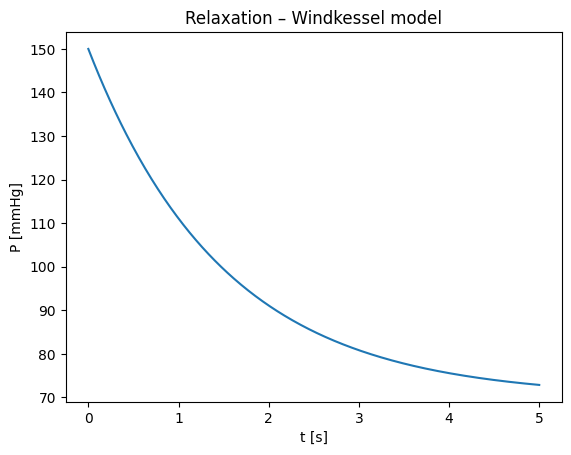

In [5]:
t = np.linspace(0, 5, 500)
model.calculate_Windkessel(Pd=70.0, Pi=150.0, R=1.5, C=1.0, t=t)
plt.plot(t, model.P_t)
plt.xlabel('t [s]')
plt.ylabel('P [mmHg]')
plt.title('Relaxation – Windkessel model')
